In [ ]:
%matplotlib inline

In [ ]:
import pyximport
import numpy as np
import menpo.io as mio
import tensorflow as tf
import losses

from evaluation import score
from pathlib import Path

slim = tf.contrib.slim
pyximport.install(setup_args={'include_dirs': [np.get_include()]})

from fast_dtw import dtw, dtw_lc
from menpo.visualize import print_progress, print_dynamic
from menpo.image import Image
cached_data_path = Path('mmi_smile.pkl')

## Load data

In [3]:
data, gnd = mio.import_pickle(cached_data_path)

## Network

In [4]:
# The input images are of size 40x40.
source_images = tf.placeholder(tf.float32, shape=(None, 40, 40, 1))
target_images = tf.placeholder(tf.float32, shape=(None, 40, 40, 1))

def network(images):
    with slim.arg_scope([slim.conv2d, slim.fully_connected], normalizer_fn=slim.batch_norm, outputs_collections='output'):
        net = slim.conv2d(images, 32, 3) # 40x40
        net = slim.max_pool2d(net, 2) # 20x20
        net = slim.conv2d(net, 32, 3) 
        net = slim.max_pool2d(net, 2) # 10x10
        net = slim.flatten(net)
        net = slim.fully_connected(net, 10, activation_fn=None)
    return net

In [5]:
with tf.variable_scope('net', reuse=False):
    source_proj = network(source_images)
    
with tf.variable_scope('net', reuse=True):
    target_proj = network(target_images)

## Define losses

In [6]:
cost = losses.correlation_cost(source_proj, target_proj, 0, 0)

opt = tf.train.AdamOptimizer(.0005)
train_op = opt.minimize(cost)

In [7]:
sess = tf.Session()

In [8]:
sess.run(tf.global_variables_initializer())

In [9]:
def init_path(source, target):
    Vs = [source, target]

    P = np.zeros((max([x.shape[0] for x in Vs]), len(Vs)), int)

    for i in range(P.shape[1]):
        P[:, i] = np.linspace(0, Vs[i].shape[0] - 1, num=P.shape[0]).round()

    return P

In [10]:
current_paths = {}
current_scores = {}

### Training

In [ ]:
num_videos = len(data)
num_epochs = 10

for epoch in range(num_epochs):
    for idx, i in enumerate(range(num_videos)):
        for j in range(num_videos):
            if j < i: continue

            if (i, j) not in current_paths:
                current_paths[(i, j)] = init_path(data[i], data[j])

            path = current_paths[(i, j)].T
            loss, _, fx, gx = sess.run((cost, train_op, source_proj, target_proj), feed_dict={
                        source_images: data[i].transpose(0, 2, 3, 1)[path[0]],
                        target_images: data[j].transpose(0, 2, 3, 1)[path[1]]
            })

            # Gets the unique observations.
            fx = fx[np.unique(path[0], return_index=True)[1]].astype(np.float)
            gx = gx[np.unique(path[1], return_index=True)[1]].astype(np.float)

            # Solves for the warping.
            path = dtw(fx, gx)
            
            valuation = score(gnd[i][path[:, 0]], gnd[j][path[:, 1]])
            current_scores[(i, j)] = valuation

            current_paths[(i, j)] = path
            mean_score = np.mean(list(current_scores.values()))

            print_dynamic("Loss: {:3f}, Score: {:.2f} {}/{} -- Epoch {}/{}".format(
                    loss[0], mean_score, idx, num_videos, epoch, num_epochs))

In [33]:
video_id = 0

f = sess.run(tf.get_collection('output')[1], feed_dict={
    source_images: data[video_id].transpose(0, 2, 3, 1),
})

In [34]:
def merge_images(*images, group=None):
    if len(images) == 1:
        images = images[0]
        
    image_widths = np.cumsum([0] + [im.shape[1] for im in images])

    merged_im = Image(np.concatenate([im.pixels for im in images], 2))
    return merged_im

In [35]:
images = [Image(data[video_id][int(i), 0]) for i in np.linspace(0, len(data[video_id])-1, 7).round()]
features = [Image(f[int(i)].mean(-1)).resize((40, 40)) for i in np.linspace(0, len(data[video_id])-1, 7).round()]

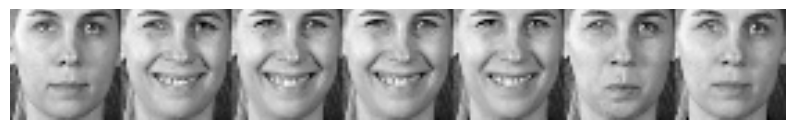

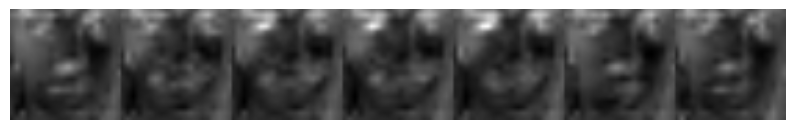

In [36]:
merge_images(*images).view()
merge_images(*features).view(new_figure=True)